In [1]:
from processing.DataPreparing import DataPreparing
from processing.forecasting_and_saving import forecasting_and_saving
from processing.validation_testing import validation_testing

from models.LightGBM_Model import LightGBM_Model
from models.MSTL_Model import MSTL_Model
from models.LinearQuantileRegression_Model import LinearQuantileRegression_Model
from models.GradientBoostingRegressor_Model import GradientBoostingRegressor_Model
from models.Baseline_Model import Baseline_Model
from hyperparameter import hyperparameters

from hyperparameter_optuna import hyperparameter_optuna
import optuna

from matplotlib import pyplot as plt
import os
from pathlib import Path
from typing import Tuple, Dict, List
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.linear_model import QuantileRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_pinball_loss
from sklearn.metrics import d2_pinball_score
from statsmodels.tsa.seasonal import MSTL
from statsforecast import StatsForecast
from statsforecast.models import MSTL

c:\Users\simon\.conda\envs\ptsc\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
plt.style.use("stylesheet.mplstyle")

# Bike data and weather data importing

In [2]:
data_preparer = DataPreparing()

# # Data Importing for bike data
# data_bike = data_preparer.get_bike_and_weather_data()
# todays_date = pd.Timestamp.now(tz=data_bike.index.tz) - pd.Timedelta(days=1)
# bike_past = data_bike.loc[data_bike.index < todays_date]
# # bike_past = bike_past.loc[bike_past.index <= '2024-11-01'] # Cut off the data at the end of the year 2024 because this will be tested !!!
# bike_past.loc[:,'bike_count'] = bike_past['bike_count'].fillna(int(data_bike['bike_count'].mean())) # Missing value for 03.01.2025
# bike_future = data_bike.loc[data_bike.index >= todays_date]

# Data Importing for the energy data
data_energy = data_preparer.get_energy_and_weather_data() # Still have to change the weather data from karslruhe to germany
reversed_nan = data_energy['consumption'][::-1].notna() # Look for the index where the nan values start to separate into past and future values
first_nan_index = reversed_nan.idxmax()
energy_past = data_energy.loc[data_energy.index <= first_nan_index]
energy_past = energy_past.loc[energy_past.index > '2022-10-29']
# energy_past = energy_past.loc[energy_past.index <= '2024-11-01'] # Cut off the data at the end of the year 2024 because this will be tested !!!
energy_future = data_energy.loc[data_energy.index > first_nan_index]


100%|██████████| 213/213 [00:17<00:00, 12.13it/s]


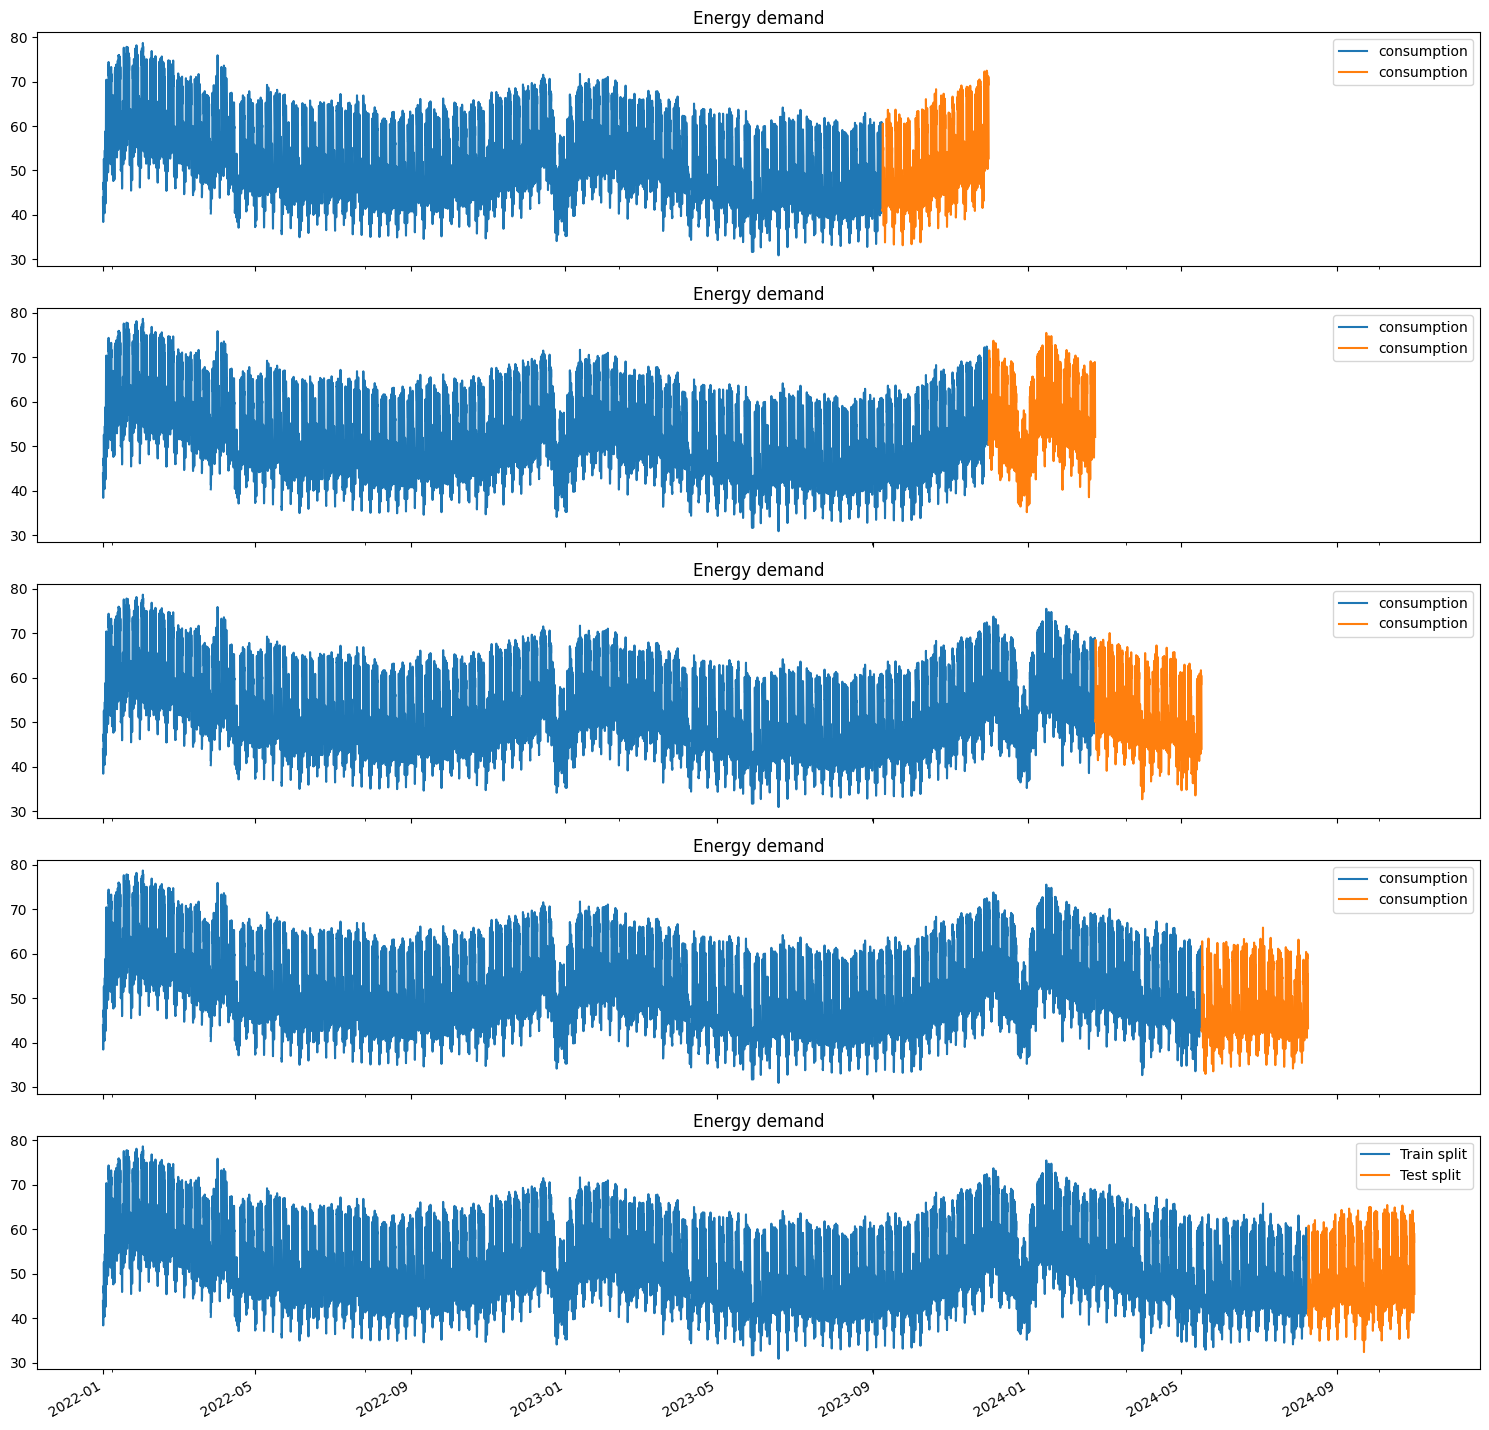

In [5]:
energy_split = energy_past[['consumption']]
tss = TimeSeriesSplit(n_splits=5, test_size=24*7*12, gap = 0) # 12 weeks

fig, axs = plt.subplots(5,1, figsize=(15,15),sharex=True)

fold = 0
for train_index, test_index in tss.split(energy_split):
    train = energy_split.iloc[train_index]
    test = energy_split.iloc[test_index]
    train.plot(ax=axs[fold], label=f'Train split {fold}', title='Energy demand')
    test.plot(ax=axs[fold], label=f'Test split {fold}')
    fold += 1
    
plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.legend(['Train split', 'Test split'])

# Feature selection

In [4]:
# removed 'snow_depth', 'soil_temperature_0_to_7cm'             
# "soil_moisture_0_to_7cm"      
FEATURES_ITERATIVE_BIKE = hyperparameters['bike']['features_for_optuna']
FEATURES_ITERATIVE_ENERGY = hyperparameters['energy']['features_for_optuna']
TARGET_bike = "bike_count"
TARGET_energy = "consumption"
FEATURES_ITERATIVE_ENERGY

['temperature_2m',
 'relative_humidity_2m',
 'dew_point_2m',
 'apparent_temperature',
 'precipitation',
 'rain',
 'snowfall',
 'pressure_msl',
 'surface_pressure',
 'cloud_cover',
 'cloud_cover_low',
 'cloud_cover_mid',
 'cloud_cover_high',
 'et0_fao_evapotranspiration',
 'vapour_pressure_deficit',
 'wind_speed_10m',
 'wind_speed_100m',
 'wind_direction_10m',
 'wind_direction_100m',
 'wind_gusts_10m',
 'wet_bulb_temperature_2m',
 'sunshine_duration',
 'shortwave_radiation',
 'direct_radiation',
 'diffuse_radiation',
 'direct_normal_irradiance',
 'global_tilted_irradiance',
 'terrestrial_radiation',
 'shortwave_radiation_instant',
 'direct_radiation_instant',
 'diffuse_radiation_instant',
 'direct_normal_irradiance_instant',
 'global_tilted_irradiance_instant',
 'terrestrial_radiation_instant',
 'month',
 'day',
 'quarter',
 'weekday',
 'lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'lag_14',
 'lag_20',
 'lag_28',
 'lag_50',
 'diff_lag_1',
 'diff_lag_2',
 'diff_la

In [ ]:
optuna_study = hyperparameter_optuna()
best_params = {}
# lightgbm
# linearquantileregression
# gradientboostingregressor
for quantile in [0.025, 0.25, 0.5, 0.75, 0.975]:
    # best_params[quantile] = optuna_study.tune_hyperparameters(bike_past, FEATURES_ITERATIVE_BIKE, "gradientboostingregressor", TARGET_bike, quantile, 5, 365, n_trials=10) # For bike data
    best_params[quantile] = optuna_study.tune_hyperparameters(energy_past.dropna(subset=['consumption']), FEATURES_ITERATIVE_ENERGY, "lightgbm", TARGET_energy, quantile, 5, 24*7*12, n_trials=50) # for energy data
print(best_params)

In [13]:
def keys_with_value_one(input_dict):
    """
    Returns a list of all keys where the value is equal to 1.

    :param input_dict: Dictionary to process
    :return: List of keys with value 1
    """
    return [key for key, value in input_dict.items() if value == 1]

keys_with_value_one(best_params[0.975])

['temperature_2m',
 'dew_point_2m',
 'rain',
 'snowfall',
 'cloud_cover',
 'cloud_cover_low',
 'cloud_cover_high',
 'vapour_pressure_deficit',
 'wind_speed_10m',
 'wind_speed_100m',
 'diffuse_radiation',
 'direct_normal_irradiance',
 'diffuse_radiation_instant',
 'direct_normal_irradiance_instant',
 'global_tilted_irradiance_instant',
 'terrestrial_radiation_instant',
 'day',
 'weekday',
 'lag_3',
 'lag_4',
 'diff_lag_1',
 'diff_lag_2',
 'diff_lag_3',
 'corona_phase',
 'rolling_mean_7',
 'rolling_std_7',
 'rolling_std_30']

In [14]:
best_params

{0.025: {'learning_rate': 0.04250556821327426,
  'n_estimators': 804,
  'num_leaves': 107,
  'reg_alpha': 0.5044005472296809,
  'temperature_2m': 1,
  'relative_humidity_2m': 0,
  'dew_point_2m': 0,
  'apparent_temperature': 1,
  'precipitation': 0,
  'rain': 1,
  'snowfall': 0,
  'pressure_msl': 1,
  'surface_pressure': 1,
  'cloud_cover': 0,
  'cloud_cover_low': 1,
  'cloud_cover_mid': 1,
  'cloud_cover_high': 0,
  'et0_fao_evapotranspiration': 0,
  'vapour_pressure_deficit': 1,
  'wind_speed_10m': 0,
  'wind_speed_100m': 1,
  'wind_direction_10m': 0,
  'wind_direction_100m': 0,
  'wind_gusts_10m': 1,
  'wet_bulb_temperature_2m': 0,
  'sunshine_duration': 1,
  'shortwave_radiation': 0,
  'direct_radiation': 1,
  'diffuse_radiation': 0,
  'direct_normal_irradiance': 1,
  'global_tilted_irradiance': 0,
  'terrestrial_radiation': 0,
  'shortwave_radiation_instant': 1,
  'direct_radiation_instant': 0,
  'diffuse_radiation_instant': 0,
  'direct_normal_irradiance_instant': 0,
  'global_ti

# Hyperparameter declaration

In [8]:
# #####################################################
# # Hyperparameters for the LightGBM model
# #####################################################
# # For bike data
# learning_rate_lightgbm_bike = hyperparameters["bike"]["lightgbm"]["learning_rate"]
# n_estimators_lightgbm_bike = hyperparameters["bike"]["lightgbm"]["n_estimators"]
# num_leaves_lightgbm_bike = hyperparameters["bike"]["lightgbm"]["num_leaves"]
# reg_alpha_lightgbm_bike = hyperparameters["bike"]["lightgbm"]["reg_alpha"]
# features_lightgbm_bike = hyperparameters["bike"]["lightgbm"]["features"]

# # For the energy data
# learning_rate_lightgbm_energy = hyperparameters["energy"]["lightgbm"]["learning_rate"]  
# n_estimators_lightgbm_energy = hyperparameters["energy"]["lightgbm"]["n_estimators"]
# num_leaves_lightgbm_energy = hyperparameters["energy"]["lightgbm"]["num_leaves"]
# reg_alpha_lightgbm_energy = hyperparameters["energy"]["lightgbm"]["reg_alpha"]
# features_lightgbm_energy = hyperparameters["energy"]["lightgbm"]["features"]

# #####################################################
# # Hyperparameters for the LinearQuantileRegression model
# #####################################################
# # For the bike data
# fit_intercept_bike = hyperparameters["bike"]["linearquantileregression"]["fit_intercept"]
# alpha_bike = hyperparameters["bike"]["linearquantileregression"]["alpha"]
# features_linearquantileregression_bike = hyperparameters["bike"]["linearquantileregression"]["features"]

# # For the energy data
# fit_intercept_energy = hyperparameters["energy"]["linearquantileregression"]["fit_intercept"]
# alpha_energy = hyperparameters["energy"]["linearquantileregression"]["alpha"]
# features_linearquantileregression_energy = hyperparameters["energy"]["linearquantileregression"]["features"]

# #####################################################
# # Hyperparameters for the Gradient Boosting model
# #####################################################
# # For the bike data (None for energy since it is not used)
# learning_rate_gradientboostingregressor = hyperparameters["bike"]["gradientboostingregressor"]["learning_rate"]
# n_estimators_gradientboostingregressor = hyperparameters["bike"]["gradientboostingregressor"]["n_estimators"]
# features_gradientboostingregressor = hyperparameters["bike"]["gradientboostingregressor"]["features"]


# #####################################################
# # Hyperparameters for the MSTL model
# #####################################################
# season_length_one_bike = hyperparameters['bike']['mstl']['season_length_one']     # weekly seasonality for bike
# season_length_two_bike = hyperparameters['bike']['mstl']['season_length_two']     # yearly seasonality for bike


# season_length_one_energy = hyperparameters['energy']['mstl']['season_length_one']     # daily seasonality for energy
# season_length_two_energy = hyperparameters['energy']['mstl']['season_length_two']     # yearly seasonality for energy


# TARGET_bike = "bike_count"
# TARGET_energy = "consumption"

# Model Training

In [11]:
TARGET_bike = "bike_count"
TARGET_energy = "consumption"

###########################
# Train the lightgbm model
###########################
lgbm = LightGBM_Model()
# For Bike data
# learning_rate_lightgbm_bike = hyperparameters["bike"]["lightgbm"]["learning_rate"]
# n_estimators_lightgbm_bike = hyperparameters["bike"]["lightgbm"]["n_estimators"]
# num_leaves_lightgbm_bike = hyperparameters["bike"]["lightgbm"]["num_leaves"]
# reg_alpha_lightgbm_bike = hyperparameters["bike"]["lightgbm"]["reg_alpha"]
# features_lightgbm_bike = hyperparameters["bike"]["lightgbm"]["features"]
# model_lgbm_bike, pred_lgbm_bike, res_lgbm_bike, y_true_dict_bike = lgbm.lightgbm_model(bike_past, features_lightgbm_bike, TARGET_bike, learning_rate_lightgbm_bike, n_estimators_lightgbm_bike, num_leaves_lightgbm_bike, reg_alpha_lightgbm_bike, [0.025, 0.25, 0.5, 0.75, 0.975], 5, 365)
# Mean pinball loss: 121.03790721534588
# Mean d2 pinball score: 0.5870761168449796
# Mean relative pinball loss: 0.027722130867105427

# For Energy data
# learning_rate_lightgbm_energy = hyperparameters["energy"]["lightgbm"]["learning_rate"]  
# n_estimators_lightgbm_energy = hyperparameters["energy"]["lightgbm"]["n_estimators"]
# num_leaves_lightgbm_energy = hyperparameters["energy"]["lightgbm"]["num_leaves"]
# reg_alpha_lightgbm_energy = hyperparameters["energy"]["lightgbm"]["reg_alpha"]
# features_lightgbm_energy = hyperparameters["energy"]["lightgbm"]["features"]
# model_lgbm_energy, pred_lgbm_energy, res_lgbm_energy, y_true_dict_engergy = lgbm.lightgbm_model(energy_past.dropna(subset=['consumption']), features_lightgbm_energy, TARGET_energy, learning_rate_lightgbm_energy, n_estimators_lightgbm_energy, num_leaves_lightgbm_energy, reg_alpha_lightgbm_energy, [0.025, 0.25, 0.5, 0.75, 0.975], 5, 168*10)
# Mean pinball loss: 0.47814893291813687
# Mean d2 pinball score: 0.578553884557176
# Mean relative pinball loss: 0.0083146967404475

###########################
# Train the MSTL model
###########################
mstl = MSTL_Model() 
# For Bike data
# season_length_one_bike = hyperparameters['bike']['mstl']['season_length_one']     # weekly seasonality for bike
# season_length_two_bike = hyperparameters['bike']['mstl']['season_length_two']    # yearly seasonality for bike
# model_mstl, pred_mstl, res_mstl = mstl.mstl_model_bike(bike_past, 700, season_length_one_bike, season_length_two_bike, [0.025, 0.25, 0.5, 0.75, 0.975], 5, 365)
# model_mstl, pred_mstl, res_mstl = mstl.mstl_model_bike_iterative(bike_past, 2000, season_length_one_bike, [0.025, 0.25, 0.5, 0.75, 0.975], 5, 30*6)
# Overall Pinball Loss': 378.28838876549054, 
# Overall Relative Pinball Loss': 0.08655247244623743, 
# Overall D2 Pinball Score': -0.5902953913202691}


# For Energy data (but runs for 117 miniutes)
# season_length_one_energy = hyperparameters['energy']['mstl']['season_length_one']     # daily seasonality for energy
# season_length_two_energy = hyperparameters['energy']['mstl']['season_length_two']     # yearly seasonality for energy
# model_mstl_energy, pred_mstl_energy, res_mstl_energy = mstl.mstl_model_energy_iterative(energy_past.dropna(subset=['consumption']), 2000, season_length_one_energy, season_length_two_energy, [0.025, 0.25, 0.5, 0.75, 0.975], 5, 168)
# Overall Pinball Loss': 0.7758117786113629, 
# 'Overall Relative Pinball Loss': 0.01438203299934493, 
# 'Overall D2 Pinball Score': 0.4124190971818901


############################################
# Train the LinearQuantileRegression model
############################################
lqr = LinearQuantileRegression_Model()
# For bike data
# fit_intercept_bike = hyperparameters["bike"]["linearquantileregression"]["fit_intercept"]
# alpha_bike = hyperparameters["bike"]["linearquantileregression"]["alpha"]
# features_linearquantileregression_bike = hyperparameters["bike"]["linearquantileregression"]["features"]
# model_lqr_bike, pred_lqr_bike, res_lqr_bike = lqr.quantile_regression_model(bike_past, features_linearquantileregression_bike, TARGET_bike, fit_intercept, alpha, [0.025, 0.25, 0.5, 0.75, 0.975], 5, 30*6)
# Mean pinball loss: 128.8552785261655
# Mean relative pinball loss: 0.03465251468381274
# Mean d2 pinball score: 0.37489821209173463

# For Energy data
# fit_intercept_energy = hyperparameters["energy"]["linearquantileregression"]["fit_intercept"]
# alpha_energy = hyperparameters["energy"]["linearquantileregression"]["alpha"]
# features_linearquantileregression_energy = hyperparameters["energy"]["linearquantileregression"]["features"]
# model_lqr_energy, pred_lqr_energy, res_lqr_energy = lqr.quantile_regression_model(energy_past.dropna(subset=['consumption']), features_linearquantileregression_energy, TARGET_energy, fit_intercept_energy[0.025], alpha_energy, [0.025, 0.25, 0.5, 0.75, 0.975], 5, 24*7*12)
# Mean pinball loss: 0.30085722061729486
# Mean relative pinball loss: 0.005350349493488741
# Mean d2 pinball score: 0.7266241551115814

###########################################
# Train the GradientBoostingRegressor model
###########################################
# gbr = GradientBoostingRegressor_Model()
# For bike data
# learning_rate_gradientboostingregressor = hyperparameters["bike"]["gradientboostingregressor"]["learning_rate"]
# n_estimators_gradientboostingregressor = hyperparameters["bike"]["gradientboostingregressor"]["n_estimators"]
# features_gradientboostingregressor = hyperparameters["bike"]["gradientboostingregressor"]["features"]
# model_gbr_bike, pred_gbr_bike, res_gbr_bike = gbr.gradientboostingregressor_model(bike_past, FEATURES_ITERATIVE, TARGET_bike, [0.025, 0.25, 0.5, 0.75, 0.975], 5, 30)
# Mean pinball loss: 76.78476140161466
# Mean relative pinball loss: 0.019371678944341976
# Mean d2 pinball score: 0.44442737284859407

# For Energy data (actually not used since too much calculation time)
# gbr = GradientBoostingRegressor_Model()
# model_gbr_energy, pred_gbr_energy, res_gbr_energy = gbr.gradientboostingregressor_model(energy_past, FEATURES_ITERATIVE, TARGET_energy, [0.025, 0.25, 0.5, 0.75, 0.975], 5, 168)

############################################
# Train the Baseline model
############################################
# baseline = Baseline_Model()
# For bike data
# pred_baseline_bike, res_baseline_bike = baseline.baseline_model(bike_past, TARGET_bike, [0.025, 0.25, 0.5, 0.75, 0.975], last_observations=100)
# Mean pinball loss: 347.4541666666667
# Mean relative pinball loss: 0.08799900633668664
# Mean d2 pinball score: -0.30794383151021376

# For Energy data
# pred_baseline_energy, res_baseline_energy = baseline.baseline_model(energy_past, TARGET_energy, [0.025, 0.25, 0.5, 0.75, 0.975], last_observations=100)


-----Train the linear quantile regression model for target consumption----
Mean pinball loss: 0.26456091123419323
Mean relative pinball loss: 0.004940953425191354
Mean d2 pinball score: 0.8378567963691042
{'quantile_0.025 Pinball Loss Mean': 0.0814953749628696, 'quantile_0.025 Relative Pinball Loss Mean': 0.0015187807450295922, 'quantile_0.025 D2 Pinball Score Mean': 0.809723976903945, 'quantile_0.25 Pinball Loss Mean': 0.33353007660831646, 'quantile_0.25 Relative Pinball Loss Mean': 0.006228750835369194, 'quantile_0.25 D2 Pinball Score Mean': 0.8803054810130313, 'quantile_0.5 Pinball Loss Mean': 0.42613081567026995, 'quantile_0.5 Relative Pinball Loss Mean': 0.007964963335704452, 'quantile_0.5 D2 Pinball Score Mean': 0.8887173145543237, 'quantile_0.75 Pinball Loss Mean': 0.38883198996794444, 'quantile_0.75 Relative Pinball Loss Mean': 0.007258795340355201, 'quantile_0.75 D2 Pinball Score Mean': 0.8616096412869492, 'quantile_0.975 Pinball Loss Mean': 0.09281629896156543, 'quantile_0.97

In [12]:
res_lqr_energy

{'quantile_0.025 Pinball Loss Mean': 0.0814953749628696,
 'quantile_0.025 Relative Pinball Loss Mean': 0.0015187807450295922,
 'quantile_0.025 D2 Pinball Score Mean': 0.809723976903945,
 'quantile_0.25 Pinball Loss Mean': 0.33353007660831646,
 'quantile_0.25 Relative Pinball Loss Mean': 0.006228750835369194,
 'quantile_0.25 D2 Pinball Score Mean': 0.8803054810130313,
 'quantile_0.5 Pinball Loss Mean': 0.42613081567026995,
 'quantile_0.5 Relative Pinball Loss Mean': 0.007964963335704452,
 'quantile_0.5 D2 Pinball Score Mean': 0.8887173145543237,
 'quantile_0.75 Pinball Loss Mean': 0.38883198996794444,
 'quantile_0.75 Relative Pinball Loss Mean': 0.007258795340355201,
 'quantile_0.75 D2 Pinball Score Mean': 0.8616096412869492,
 'quantile_0.975 Pinball Loss Mean': 0.09281629896156543,
 'quantile_0.975 Relative Pinball Loss Mean': 0.001733476869498328,
 'quantile_0.975 D2 Pinball Score Mean': 0.7489275680872719,
 'Overall Pinball Loss': 0.26456091123419323,
 'Overall Relative Pinball Loss'

# Forecasting and Saving

In [17]:
forecaster_and_saver = forecasting_and_saving()
# # For Bike data
# # Predict the future iteratively
# future_bike = forecaster_and_saver.predict_future_iterativ_bike(bike_past, bike_future, model_lgbm_bike, features_lightgbm_bike, TARGET_bike, [0.025, 0.25, 0.5, 0.75, 0.975])
# # Predict the future for the MSTL
# # future_bike_mstl = forecaster_and_saver.predict_future_mstl_bike(bike_past, model_mstl_bike, [0.025, 0.25, 0.5, 0.75, 0.975])
# # Save the forecast in the output folder
# forecaster_and_saver.save_forecasts_bike(future_bike)


# For Energy data
# Predict the future iteratively
future_energy = forecaster_and_saver.predict_future_iterative_energy(energy_past, energy_future, model_lqr_energy, features_linearquantileregression_energy, TARGET_energy, [0.025, 0.25, 0.5, 0.75, 0.975])
# Predict the future for the MSTL
# future_energy_mstl = forecaster_and_saver.predict_future_mstl_energy(energy_past.dropna(subset=['consumption']), model_mstl_energy, [0.025, 0.25, 0.5, 0.75, 0.975])
# Save the forecast in the output folder
forecaster_and_saver.save_forecasts_energy(future_energy)

Energy forecasts saved to c:\Users\simon\OneDrive\Dokumente\[1] Uni\[1] Master\3. Semester Wintersemester 2024\PTSC\Code_PTSC\Probabilistic_time_series_challenge-\output\single\2025-01-18_energy.csv


c:\Users\simon\OneDrive\Dokumente\[1] Uni\[1] Master\3. Semester Wintersemester 2024\PTSC\Code_PTSC\Probabilistic_time_series_challenge-\processing\forecasting_and_saving.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future.loc[:, f"pred_{quantile}"] = models[f"model_{quantile}"].predict(future[features[quantile]])
c:\Users\simon\OneDrive\Dokumente\[1] Uni\[1] Master\3. Semester Wintersemester 2024\PTSC\Code_PTSC\Probabilistic_time_series_challenge-\processing\forecasting_and_saving.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

In [4]:
energy_past

,consumption,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,snowfall,snow_depth,pressure_msl,...,diffuse_radiation,direct_normal_irradiance,global_tilted_irradiance,terrestrial_radiation,shortwave_radiation_instant,direct_radiation_instant,diffuse_radiation_instant,direct_normal_irradiance_instant,global_tilted_irradiance_instant,terrestrial_radiation_instant
2022-01-01 01:00:00+00:00,43.91550,9.648633,91.910058,8.378633,6.283385,0.093333,0.093333,0.0,0.000000,1020.960000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-01-01 02:00:00+00:00,41.53575,9.448633,92.279187,8.241967,6.052829,0.106667,0.106667,0.0,0.000000,1021.406667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-01-01 03:00:00+00:00,40.48075,9.275300,92.398364,8.091967,5.877336,0.053333,0.053333,0.0,0.000000,1021.693333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-01-01 04:00:00+00:00,39.56400,9.191967,92.252382,7.975300,5.845326,0.026667,0.026667,0.0,0.000000,1021.966667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-01-01 05:00:00+00:00,39.33825,8.958633,92.862136,7.838634,5.674294,0.013333,0.013333,0.0,0.000000,1022.226667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-18 12:00:00+00:00,62.20850,2.265567,79.333333,-1.432605,-0.824144,0.000000,0.000000,0.0,0.043333,1031.620000,...,102.661243,332.852857,206.266666,428.235799,203.648090,102.371389,101.276701,328.867493,203.648089,422.179846
2025-01-18 13:00:00+00:00,61.85125,2.468900,79.600000,-1.132713,-0.575129,0.000000,0.000000,0.0,0.043333,1031.073333,...,95.718360,360.653831,200.266667,397.908421,183.890737,96.143915,87.746822,331.425018,183.890739,364.451294
2025-01-18 14:00:00+00:00,59.90275,2.358900,80.866667,-0.943839,-0.657316,0.000000,0.000000,0.0,0.042667,1030.600000,...,76.251821,354.594466,157.866667,314.104293,129.092887,66.931391,62.161499,289.960059,129.092889,255.522451
2025-01-18 15:00:00+00:00,58.19850,2.142233,82.133333,-0.898270,-0.893553,0.000000,0.000000,0.0,0.042667,1030.186667,...,44.097005,285.082949,83.600001,182.537520,47.913459,22.723071,25.190388,157.292788,46.958079,102.818942


In [3]:
iteration_number = 10
validation_tester = validation_testing()
# lightgbm, linearquantileregression, ensemble, mstl, baseline
result_validation, future_dict, data_dict =  validation_tester.testing_on_validation_set_energy_test(energy_past.dropna(subset=['consumption']), iteration_number, "ensemble", hyperparameters) 

-----Train the lightgbm model-----
-----Train the linear quantile regression model for target consumption----
when call baseline                            consumption  temperature_2m  relative_humidity_2m  \
2024-10-29 00:00:00+00:00     46.74250       10.998633             94.181633   
2024-10-29 01:00:00+00:00     43.50400       10.915300             94.628645   
2024-10-29 02:00:00+00:00     42.11575       10.718633             95.230186   
2024-10-29 03:00:00+00:00     41.31950       10.588633             95.609354   
2024-10-29 04:00:00+00:00     41.69875       10.498633             95.733503   
...                                ...             ...                   ...   
2024-10-31 19:00:00+00:00     59.02500        9.898633             88.395577   
2024-10-31 20:00:00+00:00     57.18600        9.545300             89.602178   
2024-10-31 21:00:00+00:00     54.24100        9.241967             90.477663   
2024-10-31 22:00:00+00:00     51.55275        9.128633             91.0

In [4]:
result_validation

{'Calibration for iteration 0 for quantile 0.025': 0.010507246376811595,
 'Pinball loss for iteration 0 and quantile 0.025': 0.05232972749916962,
 'D2 Pinball score for iteration 0 and quantile 0.025': 0.8434311240970991,
 'Calibration for iteration 0 for quantile 0.25': 0.039855072463768126,
 'Pinball loss for iteration 0 and quantile 0.25': 0.2102083836635488,
 'D2 Pinball score for iteration 0 and quantile 0.25': 0.9259358135331364,
 'Calibration for iteration 0 for quantile 0.5': 0.12318840579710144,
 'Pinball loss for iteration 0 and quantile 0.5': 0.9202387860455901,
 'D2 Pinball score for iteration 0 and quantile 0.5': 0.7134082669957957,
 'Calibration for iteration 0 for quantile 0.75': 0.2572463768115942,
 'Pinball loss for iteration 0 and quantile 0.75': 0.9627550580439398,
 'D2 Pinball score for iteration 0 and quantile 0.75': 0.5071727183076246,
 'Calibration for iteration 0 for quantile 0.975': 0.3663043478260869,
 'Pinball loss for iteration 0 and quantile 0.975': 0.69170

In [4]:
result_validation

{'Calibration for iteration 0 for quantile 0.025': 0.3373188405797101,
 'Pinball loss for iteration 0 and quantile 0.025': 0.9543052334011025,
 'D2 Pinball score for iteration 0 and quantile 0.025': -1.8552508259141431,
 'Calibration for iteration 0 for quantile 0.25': 0.11231884057971014,
 'Pinball loss for iteration 0 and quantile 0.25': 1.234667405251428,
 'D2 Pinball score for iteration 0 and quantile 0.25': 0.5649810186759099,
 'Calibration for iteration 0 for quantile 0.5': 0.13768115942028986,
 'Pinball loss for iteration 0 and quantile 0.5': 1.5461809295295679,
 'D2 Pinball score for iteration 0 and quantile 0.5': 0.5184699027563295,
 'Calibration for iteration 0 for quantile 0.75': 0.38768115942028986,
 'Pinball loss for iteration 0 and quantile 0.75': 1.857694453807708,
 'D2 Pinball score for iteration 0 and quantile 0.75': 0.04905977877161083,
 'Calibration for iteration 0 for quantile 0.975': 0.6126811594202899,
 'Pinball loss for iteration 0 and quantile 0.975': 2.13805662

# Evaluation on completly indepdent Validationset

In [9]:
iteration_number = 10
validation_tester = validation_testing()
# lightgbm, linearquantileregression, gradientboostingregressor, ensemble, mstl, baseline
result_validation, future_dict, data =  validation_tester.testing_on_validation_set_bike(bike_past, iteration_number, "mstl", hyperparameters) 

-----Train the MSTL model for bike count-----
-----Train the MSTL model for bike count-----
-----Train the MSTL model for bike count-----
-----Train the MSTL model for bike count-----
-----Train the MSTL model for bike count-----
-----Train the MSTL model for bike count-----
-----Train the MSTL model for bike count-----
-----Train the MSTL model for bike count-----
-----Train the MSTL model for bike count-----
-----Train the MSTL model for bike count-----
Overall Pinball loss: 215.1023207860325
Overall D2 Pinball score: -0.12733691285964366
Interval Score 95%: 3198.019802474598
Interval Score 50%: 2279.4065555859647
Overall Calibration: {0.025: 0.05285714285714286, 0.25: 0.17142857142857143, 0.5: 0.2571428571428572, 0.75: 0.21428571428571427, 0.975: 0.07642857142857144}
Overall Sharpness: 2031.1827804470133


In [10]:
result_validation

{'Calibration for iteration 0 for quantile 0.025': 0.11785714285714285,
 'Pinball loss for iteration 0 and quantile 0.025': 143.67218146606118,
 'D2 Pinball score for iteration 0 and quantile 0.025': -2.8276674558149857,
 'Calibration for iteration 0 for quantile 0.25': 0.0357142857142857,
 'Pinball loss for iteration 0 and quantile 0.25': 495.23725895444966,
 'D2 Pinball score for iteration 0 and quantile 0.25': -0.582769461331422,
 'Calibration for iteration 0 for quantile 0.5': 0.07142857142857145,
 'Pinball loss for iteration 0 and quantile 0.5': 589.2075189935266,
 'D2 Pinball score for iteration 0 and quantile 0.5': -0.13966638103196627,
 'Calibration for iteration 0 for quantile 0.75': 0.1785714285714286,
 'Pinball loss for iteration 0 and quantile 0.75': 487.25121778775105,
 'D2 Pinball score for iteration 0 and quantile 0.75': -0.16294029732404458,
 'Calibration for iteration 0 for quantile 0.975': 0.11785714285714288,
 'Pinball loss for iteration 0 and quantile 0.975': 86.488

# Visualization of predictions

In [18]:
plt.style.use("stylesheet.mplstyle")

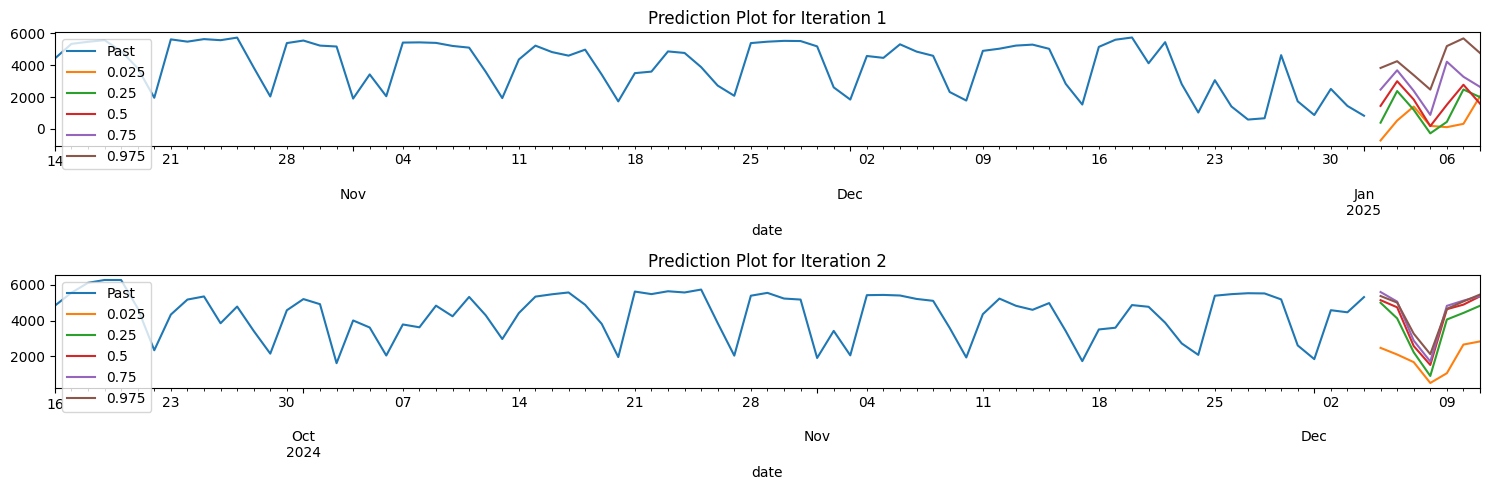

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(15, 5)) 

for i, ax in enumerate(axes, start=1): 
    # Plot data for "Train/Test_i"
    data[f'Train/Test_{i}']['bike_count'].tail(80).plot(ax=ax, label='Past')
    
    # Plot predictions for "Future_i"
    future_dict[f'Future_{i}']["pred_0.025"].plot(ax=ax, label='0.025')
    future_dict[f'Future_{i}']["pred_0.25"].plot(ax=ax, label='0.25')
    future_dict[f'Future_{i}']["pred_0.5"].plot(ax=ax, label='0.5')
    future_dict[f'Future_{i}']["pred_0.75"].plot(ax=ax, label='0.75')
    future_dict[f'Future_{i}']["pred_0.975"].plot(ax=ax, label='0.975')
    
    # Add title and legend for each subplot
    ax.set_title(f'Prediction Plot for Iteration {i}')
    ax.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()



In [30]:
future_dict

{'Future_1':                            consumption  temperature_2m  relative_humidity_2m  \
 2024-10-29 00:00:00+00:00    47.037036       10.998633             94.181633   
 2024-10-29 01:00:00+00:00    45.131311       10.915300             94.628645   
 2024-10-29 02:00:00+00:00    44.334989       10.718633             95.230186   
 2024-10-29 03:00:00+00:00    44.226597       10.588633             95.609354   
 2024-10-29 04:00:00+00:00    44.305785       10.498633             95.733503   
 ...                                ...             ...                   ...   
 2024-10-31 19:00:00+00:00    52.316088        9.898633             88.395577   
 2024-10-31 20:00:00+00:00    53.331633        9.545300             89.602178   
 2024-10-31 21:00:00+00:00    54.364059        9.241967             90.477663   
 2024-10-31 22:00:00+00:00    54.622485        9.128633             91.051312   
 2024-10-31 23:00:00+00:00    53.635703        8.918633             92.084654   
 
              

In [8]:
future_dict

{'Future_1':                            pred_0.025  pred_0.25   pred_0.5  pred_0.75  \
 2024-10-28 23:00:00+00:00   34.610933  34.610933  34.610933  34.610933   
 2024-10-29 00:00:00+00:00   33.387870  33.387870  33.387870  33.387870   
 2024-10-29 01:00:00+00:00   32.223653  32.223653  32.223653  32.223653   
 2024-10-29 02:00:00+00:00   33.211780  33.211780  33.211780  33.211780   
 2024-10-29 03:00:00+00:00   35.441771  35.441771  35.441771  35.441771   
 ...                               ...        ...        ...        ...   
 2024-10-31 16:00:00+00:00   57.273145  57.273145  57.273145  57.273145   
 2024-10-31 17:00:00+00:00   59.018551  59.018551  59.018551  59.018551   
 2024-10-31 18:00:00+00:00   58.051607  58.051607  58.051607  58.051607   
 2024-10-31 19:00:00+00:00   55.296060  55.296060  55.296060  55.296060   
 2024-10-31 20:00:00+00:00   52.325683  52.325683  52.325683  52.325683   
 
                            pred_0.975  
 2024-10-28 23:00:00+00:00   34.610933  
 202

In [18]:
energy_past

,consumption,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,snowfall,snow_depth,pressure_msl,...,diffuse_radiation,direct_normal_irradiance,global_tilted_irradiance,terrestrial_radiation,shortwave_radiation_instant,direct_radiation_instant,diffuse_radiation_instant,direct_normal_irradiance_instant,global_tilted_irradiance_instant,terrestrial_radiation_instant
2022-01-01 01:00:00+00:00,43.91550,9.648633,91.910058,8.378633,6.283385,0.093333,0.093333,0.0,0.000000,1020.960000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-01-01 02:00:00+00:00,41.53575,9.448633,92.279187,8.241967,6.052829,0.106667,0.106667,0.0,0.000000,1021.406667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-01-01 03:00:00+00:00,40.48075,9.275300,92.398364,8.091967,5.877336,0.053333,0.053333,0.0,0.000000,1021.693333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-01-01 04:00:00+00:00,39.56400,9.191967,92.252382,7.975300,5.845326,0.026667,0.026667,0.0,0.000000,1021.966667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-01-01 05:00:00+00:00,39.33825,8.958633,92.862136,7.838634,5.674294,0.013333,0.013333,0.0,0.000000,1022.226667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-18 15:00:00+00:00,58.18500,2.142233,82.133333,-0.898270,-0.893553,0.000000,0.000000,0.0,0.042667,1030.186667,...,44.097005,285.082949,83.600001,182.537520,47.913459,22.723071,25.190388,157.292788,46.958079,102.818942
2025-01-18 16:00:00+00:00,57.55325,1.825567,82.866667,-1.033758,-1.256089,0.000000,0.000000,0.0,0.042667,1029.886667,...,9.250726,74.764553,14.933333,42.929119,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2025-01-18 17:00:00+00:00,58.14900,1.405567,83.266667,-1.342684,-1.741383,0.000000,0.000000,0.0,0.042667,1029.640000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2025-01-18 18:00:00+00:00,61.01400,1.078900,83.466667,-1.619306,-2.133346,0.000000,0.000000,0.0,0.042667,1029.386667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


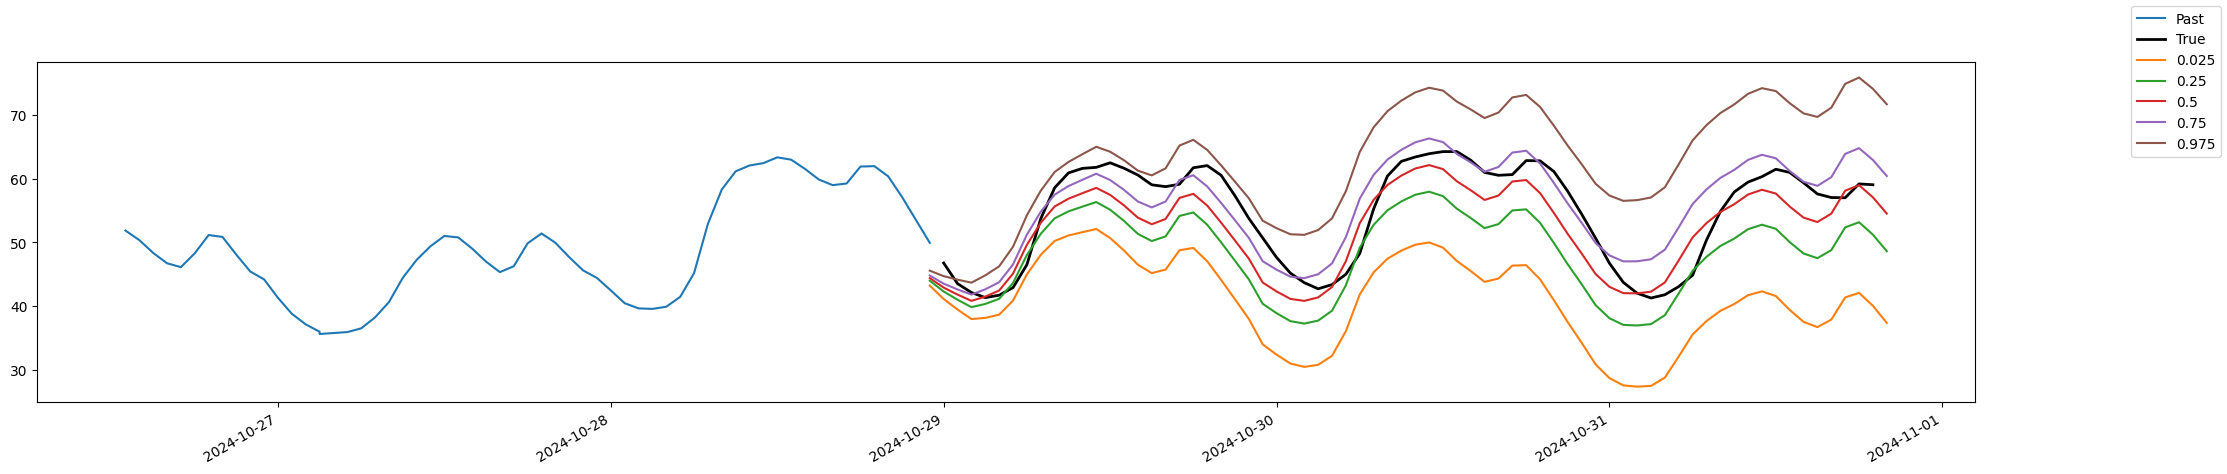

In [28]:
# Visualize the predictions for iteration 1
fig, ax = plt.subplots()
# data['Train/Test_1']['bike_count'].tail(30).plot(ax=ax, label='Past')
energy_past.loc[energy_past.index < '2024-10-29 00:00:00+00:00']['consumption'].tail(60).plot(ax=ax, label='Past')
energy_past.loc[(energy_past.index >= '2024-10-29 00:00:00+00:00') & (energy_past.index < '2024-10-31 20:00:00+00:00')]['consumption'].plot(ax=ax, label='True', color='black', linewidth=2)
future_dict['Future_1']["pred_0.025"].plot(ax=ax, label='0.025')
future_dict['Future_1']["pred_0.25"].plot(ax=ax, label='0.25')
future_dict['Future_1']["pred_0.5"].plot(ax=ax, label='0.5')
future_dict['Future_1']["pred_0.75"].plot(ax=ax, label='0.75')
future_dict['Future_1']["pred_0.975"].plot(ax=ax, label='0.975')
fig.set_size_inches(25, 5)
fig.legend()

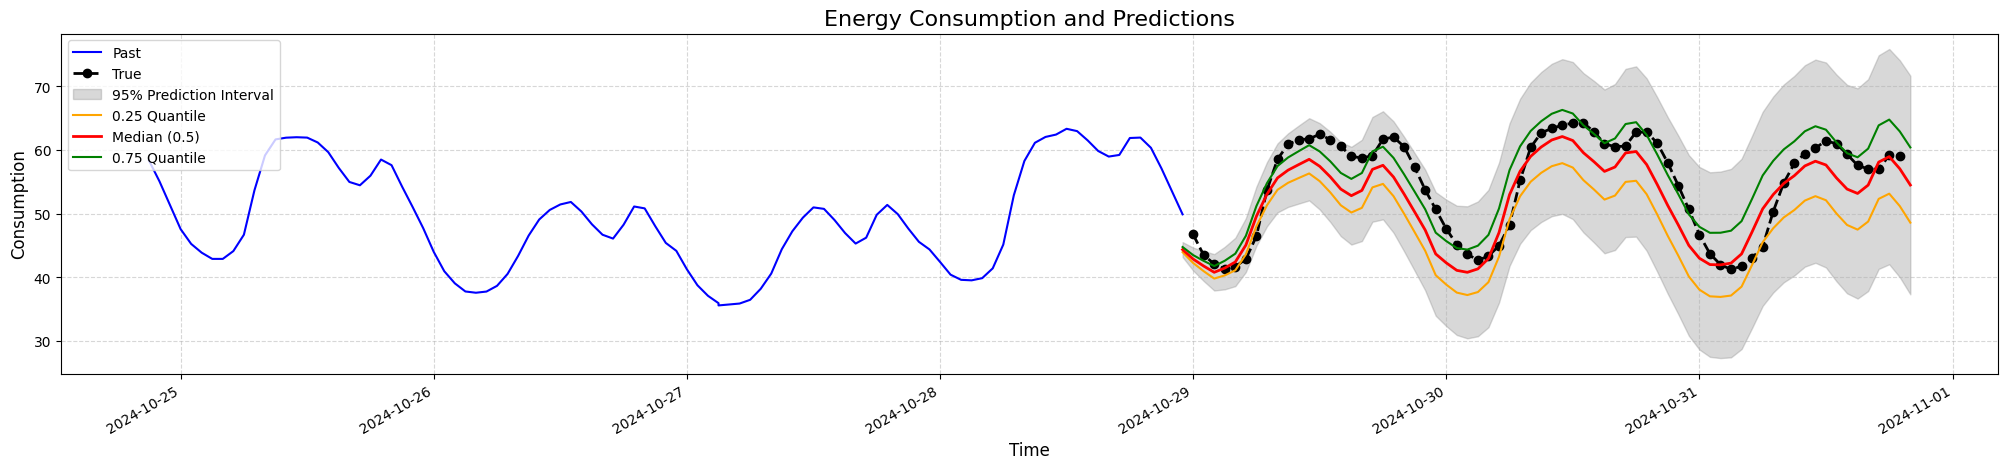

In [30]:
import matplotlib.pyplot as plt

# Create figure and axis
fig, ax = plt.subplots()

# Plot past data
energy_past.loc[energy_past.index < '2024-10-29 00:00:00+00:00']['consumption'].tail(100).plot(
    ax=ax, label='Past', color='blue', linewidth=1.5)

# Plot true data with markers
energy_past.loc[(energy_past.index >= '2024-10-29 00:00:00+00:00') & 
                (energy_past.index < '2024-10-31 20:00:00+00:00')]['consumption'].plot(
    ax=ax, label='True', color='black', linewidth=2, linestyle='--', marker='o')

# Shaded region for prediction intervals (e.g., 0.025 to 0.975)
ax.fill_between(
    future_dict['Future_1'].index, 
    future_dict['Future_1']["pred_0.025"], 
    future_dict['Future_1']["pred_0.975"], 
    color='gray', alpha=0.3, label='95% Prediction Interval')

# Plot median prediction and other quantiles with distinct colors
future_dict['Future_1']["pred_0.25"].plot(ax=ax, label='0.25 Quantile', color='orange', linewidth=1.5)
future_dict['Future_1']["pred_0.5"].plot(ax=ax, label='Median (0.5)', color='red', linewidth=2)
future_dict['Future_1']["pred_0.75"].plot(ax=ax, label='0.75 Quantile', color='green', linewidth=1.5)

# Improve figure size and layout
fig.set_size_inches(25, 5)
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_title('Energy Consumption and Predictions', fontsize=16)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Consumption', fontsize=12)

# Add legend
ax.legend(loc='upper left', fontsize=10)

# Show the plot
plt.show()


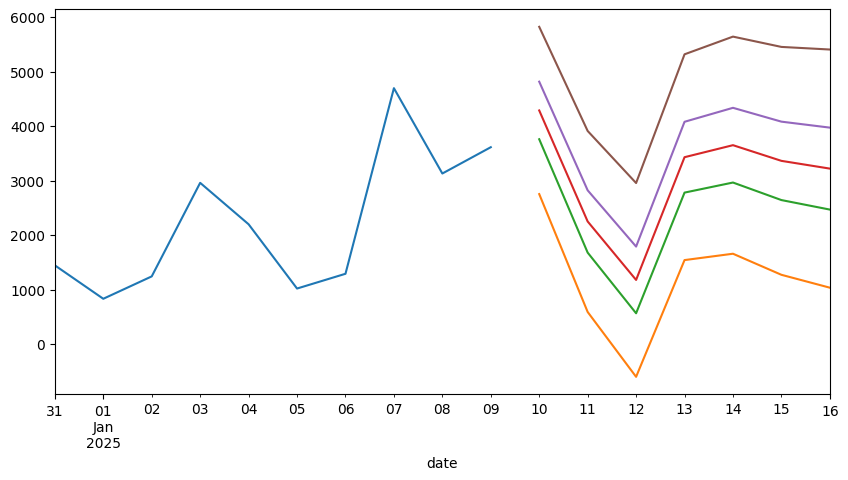

In [43]:
# Visualize the last 50 data points of the bike data and the future

fig, ax = plt.subplots()
bike_past['bike_count'].tail(10).plot(ax=ax, label='Past')
future_bike_mstl["pred_0.025"].plot(ax=ax, label='0.025')
future_bike_mstl["pred_0.25"].plot(ax=ax, label='0.25')
future_bike_mstl["pred_0.5"].plot(ax=ax, label='0.5')
future_bike_mstl["pred_0.75"].plot(ax=ax, label='0.75')
future_bike_mstl["pred_0.975"].plot(ax=ax, label='0.975')
# Change plotsize
fig.set_size_inches(10, 5)


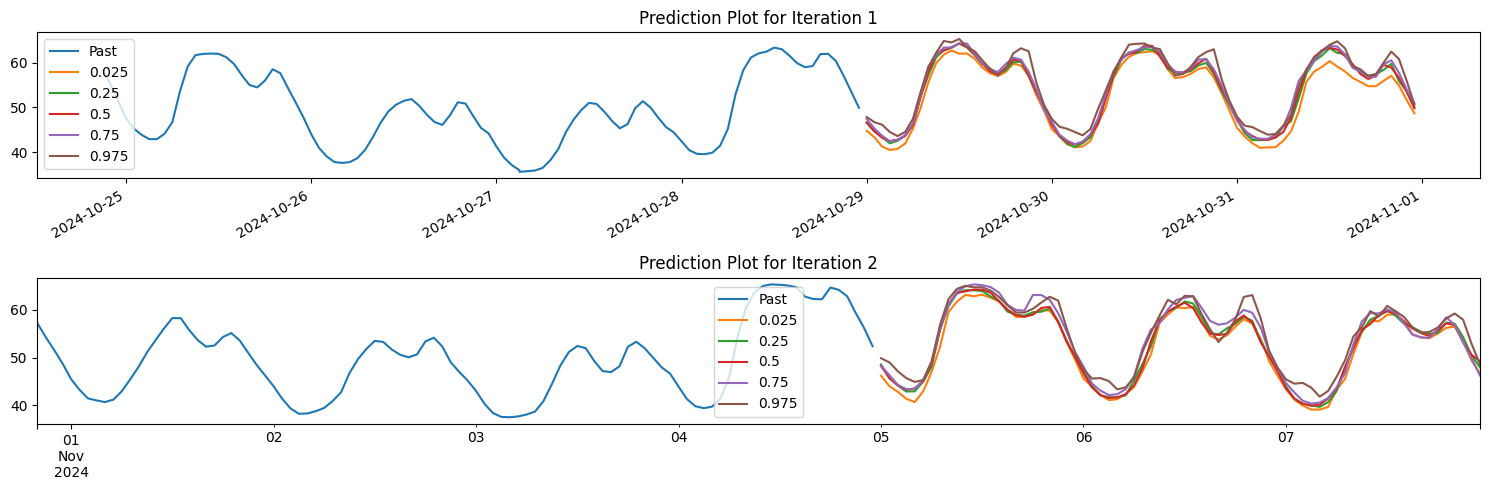

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(15, 5)) 

for i, ax in enumerate(axes, start=1): 
    # Plot data for "Train/Test_i"
    data_dict[f'Train/Test_{i}']['consumption'].tail(100).plot(ax=ax, label='Past')
    
    # Plot predictions for "Future_i"
    future_dict[f'Future_{i}']["pred_0.025"].plot(ax=ax, label='0.025')
    future_dict[f'Future_{i}']["pred_0.25"].plot(ax=ax, label='0.25')
    future_dict[f'Future_{i}']["pred_0.5"].plot(ax=ax, label='0.5')
    future_dict[f'Future_{i}']["pred_0.75"].plot(ax=ax, label='0.75')
    future_dict[f'Future_{i}']["pred_0.975"].plot(ax=ax, label='0.975')
    
    # Add title and legend for each subplot
    ax.set_title(f'Prediction Plot for Iteration {i}')
    ax.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

NameError: name 'future_energy' is not defined

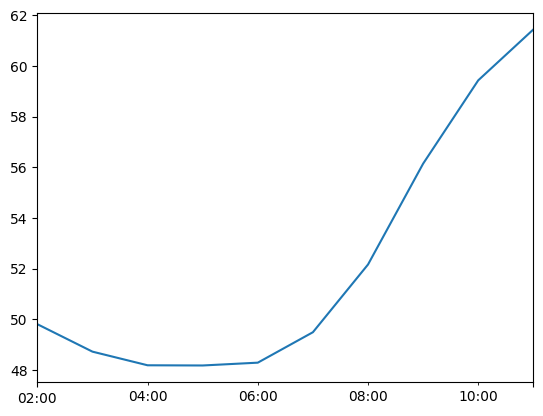

In [6]:
fig, ax = plt.subplots()
energy_past['consumption'].tail(10).plot(ax=ax, label='Past')
future_energy["pred_0.025"].plot(ax=ax, label='0.025')
future_energy["pred_0.25"].plot(ax=ax, label='0.25')
future_energy["pred_0.5"].plot(ax=ax, label='0.5')
future_energy["pred_0.75"].plot(ax=ax, label='0.75')
future_energy["pred_0.975"].plot(ax=ax, label='0.975')
# Change plotsize
fig.set_size_inches(10, 5)


# Deprecated

In [ ]:
import numpy as np

def testing_on_validation_set_bike():    
    # Data Importing
    data_preparer = DataPreparing()
    data = data_preparer.get_bike_and_weather_data()
    data.loc[:,'bike_count'] = data['bike_count'].fillna(int(data['bike_count'].mean())) 
    train = data.loc[(data.index < '12-10-2024')].copy()
    test = data.loc[(data.index >= '12-10-2024') & (data.index < '12-17-2024')].copy()

    # Train model
    lgbm = LightGBM_Model() 
    model_lgbm, pred_lgbm, res_lgbm, y_true_dict = lgbm.lightgbm_model(train, features_lightgbm_bike, TARGET_bike, learning_rate, n_estimators, num_leaves, reg_alpha, [0.025, 0.25, 0.5, 0.75, 0.975])
    
    forecaster_and_saver = forecasting_and_saving()
    future = forecaster_and_saver.predict_future_iterativ_bike(bike_past, bike_future, model_lgbm, features_lightgbm_bike, TARGET_bike, [0.025, 0.25, 0.5, 0.75, 0.975])
    
    pinnball_loss_each_quantile_lightgbm = []
    for quantile in [0.025, 0.25, 0.5, 0.75, 0.975]:
        pinnball_loss = mean_pinball_loss(test["bike_count"], future[f"pred_{quantile}"])
        print("test bike count", test["bike_count"])
        print("y_pred", future[f"pred_{quantile}"])
        pinnball_loss_each_quantile_lightgbm.append(pinnball_loss)
        print(f"Pinball loss for quantile {quantile}: {pinnball_loss}")

    print(f"Mean pinball loss: {np.mean(pinnball_loss_each_quantile_lightgbm)}")

testing_on_validation_set_bike()

def testing_on_validation_set_energy():    
    # Data Importing
    data_preparer = DataPreparing()
    data_energy = data_preparer.get_energy_and_weather_data() # Still have to change the weather data from karslruhe to germany
    train = data_energy.loc[(data_energy.index < '12-10-2024')].copy()
    test = data_energy.loc[(data_energy.index >= '12-10-2024') & (data_energy.index < '12-12-2024')].copy()

    # Train model
    lgr = LinearQuantileRegression_Model() 
    model_lqr, pred_lqr, res_lqr = lgr.quantile_regression_model_iterative(train.dropna(subset=['consumption']).tail(1500), FEATURES_ITERATIVE, TARGET_energy, fit_intercept, alpha, [0.025, 0.25, 0.5, 0.75, 0.975])
    
    forecaster_and_saver = forecasting_and_saving()
    future = forecaster_and_saver.predict_future_iterative_energy(energy_past, energy_future, model_lqr, FEATURES_ITERATIVE, TARGET_energy, [0.025, 0.25, 0.5, 0.75, 0.975])
    
    pinnball_loss_each_quantile_lightgbm = []
    for quantile in [0.025, 0.25, 0.5, 0.75, 0.975]: # Change here so I really just evaluate on the right values (not all forecasts) but maybe even better like this
        pinnball_loss = mean_pinball_loss(test["consumption"], future[f"pred_{quantile}"])
        pinnball_loss_each_quantile_lightgbm.append(pinnball_loss)
        print(f"Pinball loss for quantile {quantile}: {pinnball_loss}")

    print(f"Mean pinball loss: {np.mean(pinnball_loss_each_quantile_lightgbm)}")

# testing_on_validation_set_energy()

In [ ]:
def keys_with_value_one(input_dict):
    """
    Returns a list of all keys where the value is equal to 1.

    :param input_dict: Dictionary to process
    :return: List of keys with value 1
    """
    return [key for key, value in input_dict.items() if value == 1]

keys_with_value_one(best_params[0.975])

In [ ]:
# fmt: off
# features_lightgbm_bike = { # These features are now fixed for the different quantiles
#     0.025:   ['apparent_temperature', 'rain','pressure_msl', 'surface_pressure',  'wind_gusts_10m', 'sunshine_duration',
#                 'direct_normal_irradiance', 'terrestrial_radiation', 'direct_radiation_instant', 'diffuse_radiation_instant',
#                 'month', 'day', 'weekday','lag_2', 'lag_3', 'lag_4', 'lag_6', 'lag_7', 'lag_20', 'lag_28', 'diff_lag_2', 
#                 'diff_lag_3', 'is_holiday', 'rolling_mean_7','rolling_mean_30', 'rolling_std_30', 'diff_prev_day', 'year'],
#     0.25:   ['temperature_2m', 'dew_point_2m', 'apparent_temperature', 'rain', 'snowfall', 'pressure_msl', 'surface_pressure',
#                 'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'et0_fao_evapotranspiration', 'vapour_pressure_deficit',
#                 'wind_gusts_10m', 'wet_bulb_temperature_2m', 'direct_radiation', 'direct_normal_irradiance', 'terrestrial_radiation',
#                 'lag_4', 'lag_5', 'lag_7', 'lag_14', 'lag_20', 'lag_28', 'lag_50', 'diff_lag_2', 'is_holiday', 'corona_phase',
#                 'rolling_mean_7', 'rolling_mean_30', 'rolling_std_7', 'rolling_std_30', 'diff_prev_day', 'year'],
#     0.5:    ['relative_humidity_2m', 'apparent_temperature', 'rain', 'snowfall', 'pressure_msl', 'cloud_cover', 'cloud_cover_mid',
#                 'cloud_cover_high', 'et0_fao_evapotranspiration', 'wind_speed_10m', 'wind_speed_100m', 'wind_direction_100m',
#                 'wind_gusts_10m', 'wet_bulb_temperature_2m', 'sunshine_duration', 'direct_radiation', 'diffuse_radiation',
#                 'global_tilted_irradiance', 'lag_1', 'lag_2', 'lag_5', 'lag_6', 'lag_7', 'lag_14', 'lag_20', 'lag_28', 'lag_50',
#                 'diff_lag_3', 'diff_lag_4', 'is_holiday', 'corona_phase', 'rolling_mean_7', 'rolling_std_7', 'rolling_std_30'],
#     0.75:   ['apparent_temperature', 'precipitation', 'rain', 'snowfall', 'pressure_msl', 'surface_pressure', 'cloud_cover',
#                 'cloud_cover_low', 'wind_speed_100m', 'wind_direction_100m', 'wet_bulb_temperature_2m', 'sunshine_duration',
#                 'direct_radiation', 'direct_normal_irradiance', 'terrestrial_radiation', 'shortwave_radiation_instant',
#                 'diffuse_radiation_instant', 'global_tilted_irradiance_instant', 'month', 'quarter', 'weekday', 'lag_1', 'lag_4',
#                 'lag_5', 'lag_7', 'lag_14', 'lag_20', 'diff_lag_1', 'diff_lag_2', 'diff_lag_3', 'diff_lag_4', 'is_holiday',
#                 'rolling_mean_7', 'rolling_mean_30', 'rolling_std_30', 'diff_prev_day', 'year'],
#     0.975:  ['dew_point_2m', 'apparent_temperature', 'precipitation', 'rain', 'snowfall', 'pressure_msl', 'et0_fao_evapotranspiration',
#                 'vapour_pressure_deficit', 'wind_speed_10m', 'diffuse_radiation_instant', 'direct_normal_irradiance_instant',
#                 'global_tilted_irradiance_instant', 'terrestrial_radiation_instant', 'month', 'weekday', 'quarter', 'lag_4', 'lag_7',
#                 'diff_lag_1', 'diff_lag_2', 'diff_lag_3', 'is_holiday', 'rolling_mean_7', 'rolling_mean_30', 'diff_prev_day', 'year']
# }
features_lightgbm_energy = { # These features are now fixed for the different quantiles
    0.025:   ['apparent_temperature', 'rain','pressure_msl', 'surface_pressure',  'wind_gusts_10m', 'sunshine_duration',
                'direct_normal_irradiance', 'terrestrial_radiation', 'direct_radiation_instant', 'diffuse_radiation_instant',
                'month', 'day', 'weekday','lag_2', 'lag_3', 'lag_4', 'lag_6', 'lag_7', 'lag_20', 'lag_28', 'diff_lag_2', 
                'diff_lag_3', 'is_holiday', 'rolling_mean_7','rolling_mean_30', 'rolling_std_30', 'diff_prev_day', 'year'],
    0.25:   ['temperature_2m', 'dew_point_2m', 'apparent_temperature', 'rain', 'snowfall', 'pressure_msl', 'surface_pressure',
                'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'et0_fao_evapotranspiration', 'vapour_pressure_deficit',
                'wind_gusts_10m', 'wet_bulb_temperature_2m', 'direct_radiation', 'direct_normal_irradiance', 'terrestrial_radiation',
                'lag_4', 'lag_5', 'lag_7', 'lag_14', 'lag_20', 'lag_28', 'lag_50', 'diff_lag_2', 'is_holiday', 'corona_phase',
                'rolling_mean_7', 'rolling_mean_30', 'rolling_std_7', 'rolling_std_30', 'diff_prev_day', 'year'],
    0.5:    ['relative_humidity_2m', 'apparent_temperature', 'rain', 'snowfall', 'pressure_msl', 'cloud_cover', 'cloud_cover_mid',
                'cloud_cover_high', 'et0_fao_evapotranspiration', 'wind_speed_10m', 'wind_speed_100m', 'wind_direction_100m',
                'wind_gusts_10m', 'wet_bulb_temperature_2m', 'sunshine_duration', 'direct_radiation', 'diffuse_radiation',
                'global_tilted_irradiance', 'lag_1', 'lag_2', 'lag_5', 'lag_6', 'lag_7', 'lag_14', 'lag_20', 'lag_28', 'lag_50',
                'diff_lag_3', 'diff_lag_4', 'is_holiday', 'corona_phase', 'rolling_mean_7', 'rolling_std_7', 'rolling_std_30'],
    0.75:   ['apparent_temperature', 'precipitation', 'rain', 'snowfall', 'pressure_msl', 'surface_pressure', 'cloud_cover',
                'cloud_cover_low', 'wind_speed_100m', 'wind_direction_100m', 'wet_bulb_temperature_2m', 'sunshine_duration',
                'direct_radiation', 'direct_normal_irradiance', 'terrestrial_radiation', 'shortwave_radiation_instant',
                'diffuse_radiation_instant', 'global_tilted_irradiance_instant', 'month', 'quarter', 'weekday', 'lag_1', 'lag_4',
                'lag_5', 'lag_7', 'lag_14', 'lag_20', 'diff_lag_1', 'diff_lag_2', 'diff_lag_3', 'diff_lag_4', 'is_holiday',
                'rolling_mean_7', 'rolling_mean_30', 'rolling_std_30', 'diff_prev_day', 'year'],
    0.975:  ['dew_point_2m', 'apparent_temperature', 'precipitation', 'rain', 'snowfall', 'pressure_msl', 'et0_fao_evapotranspiration',
                'vapour_pressure_deficit', 'wind_speed_10m', 'diffuse_radiation_instant', 'direct_normal_irradiance_instant',
                'global_tilted_irradiance_instant', 'terrestrial_radiation_instant', 'month', 'weekday', 'quarter', 'lag_4', 'lag_7',
                'diff_lag_1', 'diff_lag_2', 'diff_lag_3', 'is_holiday', 'rolling_mean_7', 'rolling_mean_30', 'diff_prev_day', 'year']
}


# fmt: on

In [ ]:
# fmt: off
features_linearquantileregression_bike = { # THis is finished (On the large test set)
    0.025: ['temperature_2m', 'precipitation', 'snowfall', 'cloud_cover_low',
            'cloud_cover_high', 'wind_speed_10m', 'wind_speed_100m',
            'wind_direction_100m', 'sunshine_duration', 'global_tilted_irradiance',
            'terrestrial_radiation', 'day', 'quarter', 'weekday', 'lag_4',
            'lag_5', 'lag_28', 'lag_50', 'diff_lag_3', 'diff_lag_4', 'is_holiday',
            'corona_phase', 'rolling_mean_30', 'year'],
    0.25: ['dew_point_2m', 'apparent_temperature', 'precipitation', 'pressure_msl',
           'et0_fao_evapotranspiration', 'wind_speed_10m', 'wind_speed_100m',
            'wind_direction_100m', 'sunshine_duration', 'direct_normal_irradiance',
            'global_tilted_irradiance', 'terrestrial_radiation', 'direct_radiation_instant',
            'quarter', 'weekday', 'lag_1', 'lag_4', 'lag_5', 'lag_7', 'lag_14', 'lag_28',
            'diff_lag_2', 'diff_lag_3', 'is_holiday', 'corona_phase', 'diff_prev_day'],
    0.5: ['temperature_2m', 'relative_humidity_2m', 'precipitation', 'rain', 'surface_pressure',
          'cloud_cover', 'cloud_cover_low', 'cloud_cover_high', 'et0_fao_evapotranspiration',
          'vapour_pressure_deficit', 'wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m',
          'wind_gusts_10m', 'wet_bulb_temperature_2m', 'direct_radiation', 'direct_normal_irradiance',
          'direct_radiation_instant', 'direct_normal_irradiance_instant', 'terrestrial_radiation_instant',
           'month', 'day', 'quarter', 'weekday', 'lag_2', 'lag_3', 'lag_4', 'lag_6', 'lag_7', 'lag_14',
            'lag_20', 'lag_28', 'lag_50', 'diff_lag_1', 'diff_lag_2', 'diff_lag_3', 'diff_lag_4', 'is_holiday',
            'rolling_mean_7', 'rolling_mean_30', 'rolling_std_30', 'year'],
    0.75: ['temperature_2m', 'relative_humidity_2m', 'apparent_temperature', 'pressure_msl', 
           'surface_pressure',  'cloud_cover', 'cloud_cover_high', 'wind_speed_100m', 
            'wet_bulb_temperature_2m',  'sunshine_duration', 'shortwave_radiation', 'diffuse_radiation',
            'direct_normal_irradiance', 'global_tilted_irradiance', 'shortwave_radiation_instant', 
            'direct_radiation_instant', 'month', 'day', 'weekday', 'lag_2', 'lag_4', 'lag_6', 
            'lag_20', 'lag_28', 'lag_50', 'diff_lag_1', 'diff_lag_2', 'diff_lag_4', 'is_holiday',
            'rolling_mean_7', 'rolling_std_7', 'diff_prev_day'],
    0.975: ['temperature_2m', 'precipitation', 'rain', 'pressure_msl', 'surface_pressure', 'cloud_cover',
            'cloud_cover_low', 'wind_direction_100m', 'wet_bulb_temperature_2m', 'sunshine_duration',
            'direct_radiation', 'diffuse_radiation','direct_normal_irradiance', 'direct_radiation_instant',
            'direct_normal_irradiance_instant', 'global_tilted_irradiance_instant', 'weekday', 'lag_2',
             'lag_3', 'lag_5', 'lag_6', 'lag_7', 'lag_14', 'lag_20', 'lag_28', 'lag_50', 'diff_lag_2',
              'is_holiday', 'rolling_mean_7', 'rolling_mean_30', 'rolling_std_30', 'year' ],
}
#  fmt: on

alpha = {
    0.025: 0.00011033481513836356,
    0.25: 3.733460861903541e-05,
    0.5: 0.00012765214862505564,
    0.75: 0.001978444138077672,
    0.975: 0.00093913020701894,
}